In [1]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
# STEP 2: Import libraries
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

**DCGAN with CIFAR-10**

In [3]:
# STEP 3: Define transformation pipeline for CIFAR-10
# -----------------------------------------------
# - Resize (optional, CIFAR-10 is 32x32 already)
# - ToTensor() converts image to [C, H, W] and scales [0, 255] → [0.0, 1.0]
# - Normalize to [-1, 1] to match Tanh output of Generator
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # For 3 channels (R,G,B)
])

In [4]:
# STEP 4: Load CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:12<00:00, 13.4MB/s]


In [5]:
# STEP 5: Define Generator
# -----------------------------------------------
# Input: random noise z (e.g. [100, 1, 1])
# Output: 3x32x32 fake image via upsampling using ConvTranspose2d
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_g=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_g * 8, 4, 1, 0),  # Output: 4x4
            nn.BatchNorm2d(feature_g * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_g * 8, feature_g * 4, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(feature_g * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_g * 4, feature_g * 2, 4, 2, 1),  # 16x16
            nn.BatchNorm2d(feature_g * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_g * 2, feature_g, 4, 2, 1),  # 32x32
            nn.BatchNorm2d(feature_g),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_g, img_channels, 3, 1, 1),  # 32x32
            nn.Tanh()  # Scale outputs to [-1, 1] to match normalized images
        )

    def forward(self, z):
        return self.net(z)

In [6]:
# STEP 6: Define Discriminator
# -----------------------------------------------
# Input: real or fake 3x32x32 image
# Output: scalar between 0 (fake) and 1 (real)
# Uses Conv2d to progressively downsample the image
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_d=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, feature_d, 4, 2, 1),  # 16x16
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_d, feature_d * 2, 4, 2, 1),  # 8x8
            nn.BatchNorm2d(feature_d * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_d * 2, feature_d * 4, 4, 2, 1),  # 4x4
            nn.BatchNorm2d(feature_d * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_d * 4, 1, 4, 1, 0),  # 1x1
            nn.Sigmoid()  # Output a probability
        )

    def forward(self, x):
        return self.net(x).view(-1)


In [7]:
# STEP 7: Initialize everything
device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 100
lr = 2e-4

G = Generator(z_dim).to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy for classification loss

opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Fixed noise for visualizing how generator improves over time
fixed_noise = torch.randn(64, z_dim, 1, 1).to(device)

Epoch [1/5] | Loss D: 0.7890 | Loss G: 3.2394


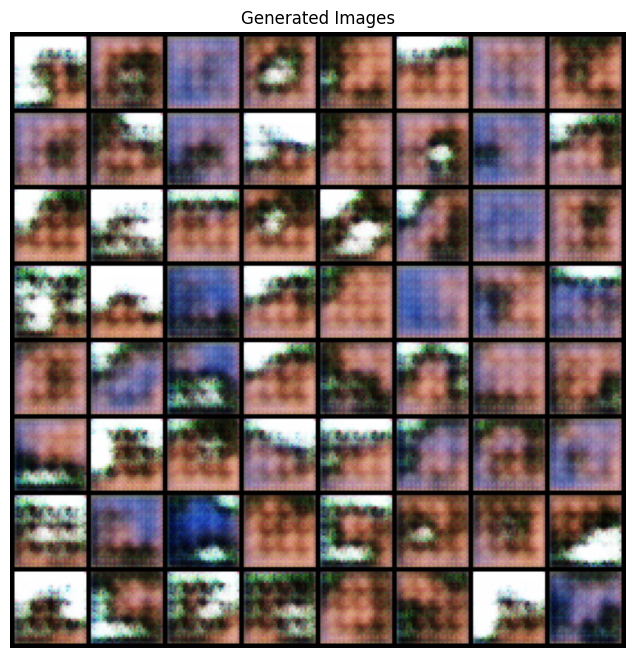

Epoch [2/5] | Loss D: 0.9340 | Loss G: 1.9732


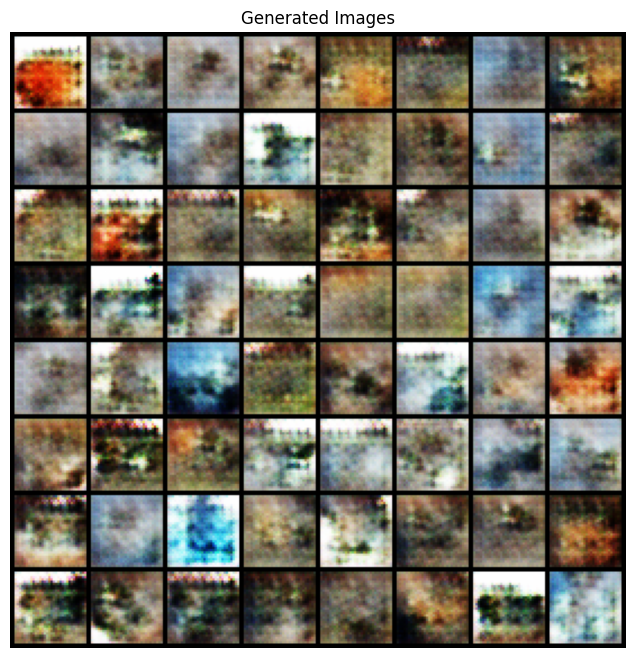

Epoch [3/5] | Loss D: 0.8093 | Loss G: 2.9984


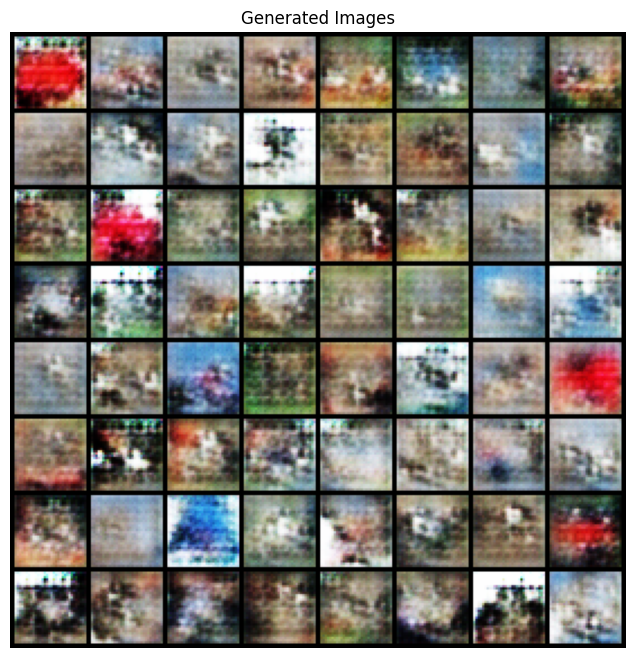

Epoch [4/5] | Loss D: 0.7161 | Loss G: 2.4193


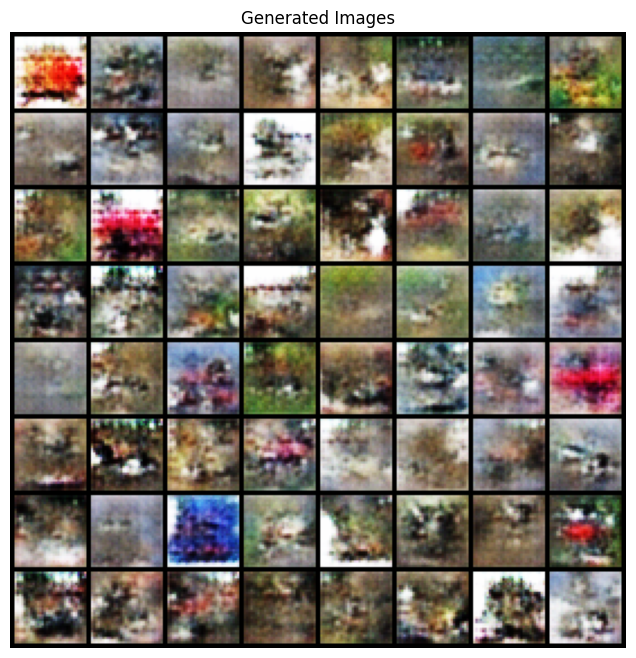

Epoch [5/5] | Loss D: 1.1986 | Loss G: 1.6253


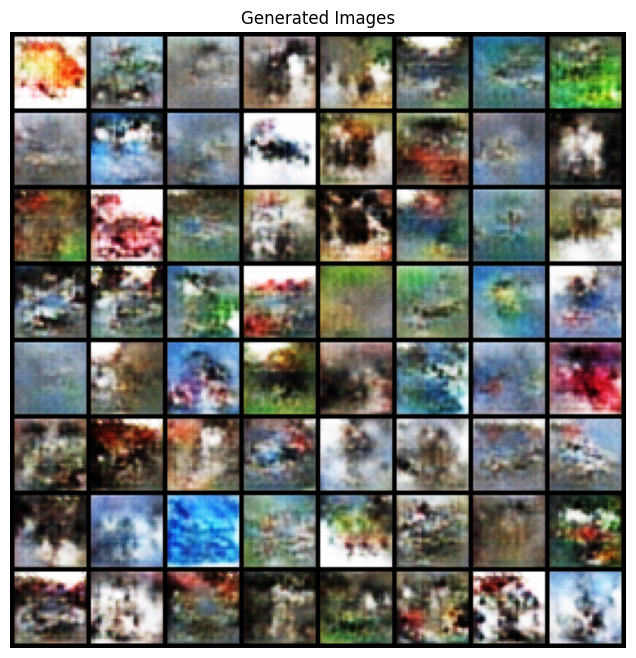

In [8]:
# STEP 8: Training loop
epochs = 5
for epoch in range(epochs):
    for real, _ in dataloader:
        real = real.to(device)
        batch_size = real.size(0)

        ### Train Discriminator ###
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = G(noise)

        D_real = D(real)
        D_fake = D(fake.detach())

        real_labels = torch.ones_like(D_real)
        fake_labels = torch.zeros_like(D_fake)

        loss_D_real = criterion(D_real, real_labels)
        loss_D_fake = criterion(D_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        ### Train Generator ###
        # Generator wants discriminator to think fake images are real (label=1)
        output = D(fake)
        loss_G = criterion(output, torch.ones_like(output))

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()
    # Log progress
    print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

    # Show generated samples
    with torch.no_grad():
        fake_images = G(fixed_noise).detach().cpu()
        grid = vutils.make_grid(fake_images, normalize=True)
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.show()

Summary: Why Each Step Matters
Normalize to [-1, 1] → Matches Tanh() output of generator.

Generator → Upsamples noise to image using ConvTranspose2d.

Discriminator → Downsamples image to classify real vs fake.

Two separate losses → D tries to distinguish real/fake, G tries to fool D.

Fixed noise → Lets you see how outputs improve each epoch.

Adam optimizers with β=(0.5, 0.999) → Recommended settings from the DCGAN paper for stability.